In [1]:
#import warnings
#warnings.simplefilter('ignore')

In [2]:
import pymc3 as pm
from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt
import arviz as az

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


### Task 1: Adjust for confounding on fork

The assumption is that if two variables ($X$, $Y$) are causally not connected by  a common cause ($Z$), there will be no association between X and Y conditional on $Z$. Without conditioning on $Z$, however, $X$ and $Y$ will be associated. This will be shown by fitting a linear regression model to simulated data, where the data-generating process if fully known. The conditioning will be done by including $Z$ into the linear regression model. 

In [20]:
# Defining the data generating process

# Defining common cause as normal distributed random variable
# Drawing 100 values from the distribution
sample_size = 1000

z = norm(5, 1)
z_values = z.rvs(size=sample_size)

# Defining normally distributed noise
noise = norm(1, 0.5)
noise_values_x = noise.rvs(size=sample_size)
noise_values_y = noise.rvs(size=sample_size)

# Defining X, which is a function of Z and noise
x_values = 0.5 * z_values + noise_values_x

# Defining Y, which is a function of Z and noise
y_values = 10 * z_values + noise_values_y + 1

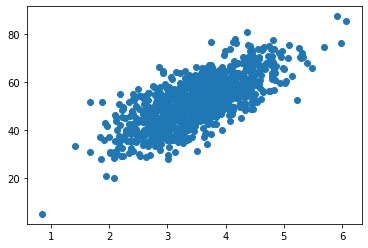

In [21]:
plt.scatter(x_values, y_values)

In [22]:
# Trying to recover the true causal values with bayesian modeling

confounded_model = pm.Model()

with confounded_model:
    
    # Priors for unknown
    intercept = pm.Normal("intercept", mu=0, sigma=10)
    x_infl = pm.Normal("x_infl", mu=0, sigma=10)
    sigma = pm.HalfNormal("sigma", sigma=1)
    
    # Expected value of outcome
    mu = intercept + x_infl * x_values
    
    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal("Y_obs", mu=mu, sigma=sigma, observed=y_values)

In [23]:
map_estimate = pm.find_MAP(model=confounded_model)
map_estimate

{'intercept': array(15.8659877),
 'x_infl': array(10.34779537),
 'sigma_log__': array(1.91513816),
 'sigma': array(6.78787655)}

In [24]:
unconfounded_model = pm.Model()

with unconfounded_model:
    
    # Priors for unknown
    intercept = pm.Normal("intercept", mu=0, sigma=10)
    x_infl = pm.Normal("x_infl", mu=0, sigma=10)
    z_infl = pm.Normal("z_infl", mu=0, sigma=10)
    sigma = pm.HalfNormal("sigma", sigma=1)
    
    # Expected value of outcome
    mu = intercept + x_infl * x_values + z_infl * z_values
    
    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal("Y_obs", mu=mu, sigma=sigma, observed=y_values)

In [26]:
map_estimate = pm.find_MAP(model=unconfounded_model)
map_estimate

{'intercept': array(2.06066041),
 'x_infl': array(-0.00850154),
 'z_infl': array(9.99077503),
 'sigma_log__': array(-0.70462193),
 'sigma': array(0.49429542)}

In [27]:
with unconfounded_model:
    trace = pm.sample(1000, return_inferencedata=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, z_infl, x_infl, intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 22 seconds.


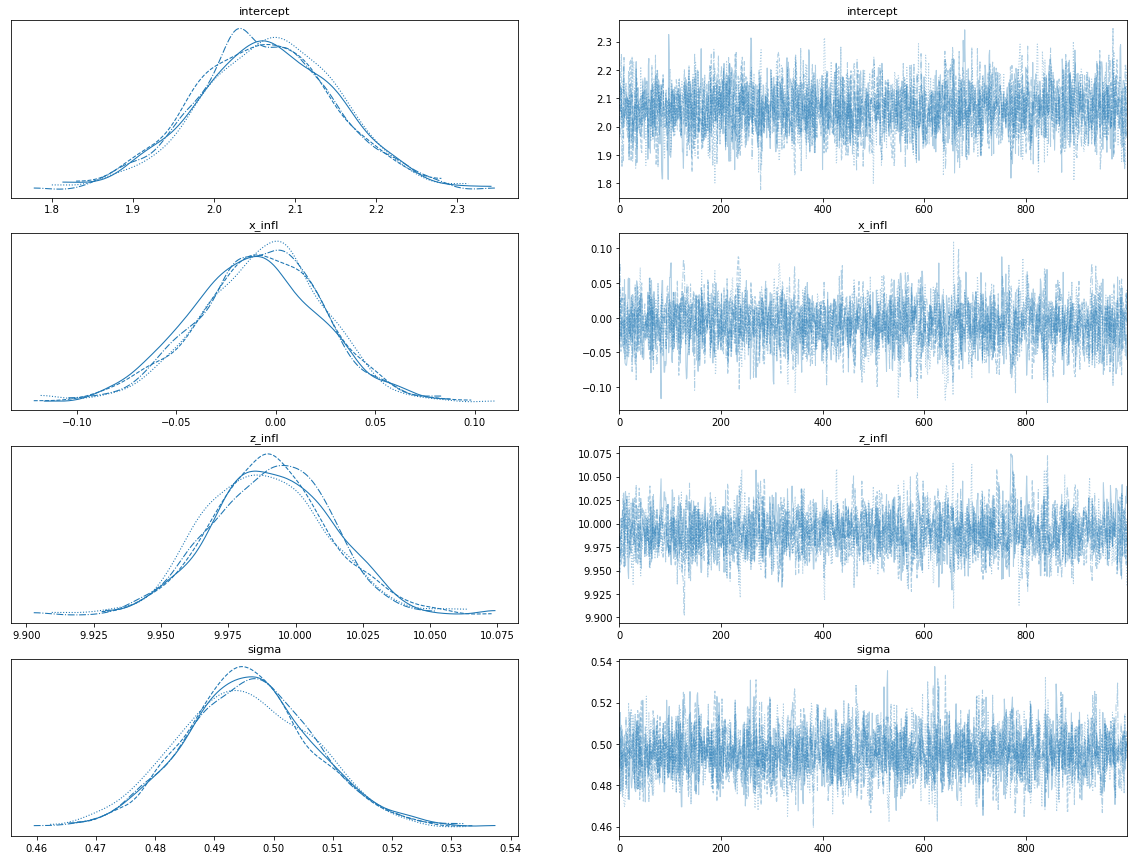

In [28]:
with unconfounded_model:
    az.plot_trace(trace, figsize=(20, 15))

### Task 2: Erase causal influence of cause by conditioning on mediator on Chain

The assumption is that if two variables ($X$, $Y$) are causally connected  but only by a mediator ($Z$). Thre graph structure therefore is $X -> Z -> Y$.
Corresponding to this data-generating process $X$ and $Y$ should be correlated. But if adjusted for (conditioned on) $Z$, there should be no correlation visible as all the information provided by $X$ for the prediction of $Y$ is mediated by $Z$.
The conditioning will be done by including $Z$ into the linear regression model. 

In [53]:
# Defining the data generating process

# Defining common cause as normal distributed random variable
# Drawing 100 values from the distribution
sample_size = 1000

# Defining normally distributed noise
noise_z = np.random.rand(sample_size)
noise_y = np.random.rand(sample_size)

# Defining X
x = norm(5, 1)
x_values = x.rvs(size=sample_size)

# Defining Z, which is a function of X and noise
z_values = 0.5 * x_values + noise_z

# Defining Y, which is a function of Z and noise
y_values = 10 * z_values + noise_y + 5

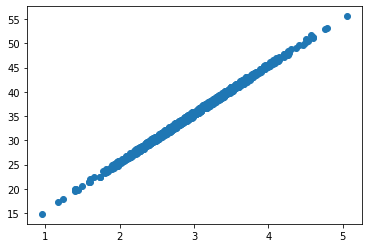

In [54]:
plt.scatter(z_values, y_values)

In [55]:
# Mediator is not included into model; influence of X on Y should be visible

model_without_mediator = pm.Model()

with model_without_mediator:
    
    # Priors for unknown
    intercept = pm.Normal("intercept", mu=0, sigma=10)
    x_infl = pm.Normal("x_infl", mu=0, sigma=10)
    sigma = pm.HalfNormal("sigma", sigma=1)
    
    # Expected value of outcome
    mu = intercept + x_infl * x_values
    
    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal("Y_obs", mu=mu, sigma=sigma, observed=y_values)

In [56]:
map_estimate = pm.find_MAP(model=model_without_mediator)
map_estimate

{'intercept': array(10.63675415),
 'x_infl': array(4.96784833),
 'sigma_log__': array(1.04718079),
 'sigma': array(2.84960614)}

In [57]:
# Mediator is included into model; influence of X on Y should not be visible anymore. But influence of Z on Y should be truely recovered.

model_mediator = pm.Model()

with model_mediator:
    
    # Priors for unknown
    intercept = pm.Normal("intercept", mu=0, sigma=10)
    x_infl = pm.Normal("x_infl", mu=0, sigma=10)
    z_infl = pm.Normal("z_infl", mu=0, sigma=10)
    sigma = pm.HalfNormal("sigma", sigma=1)
    
    # Expected value of outcome
    mu = intercept + x_infl * x_values + z_infl * z_values
    
    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal("Y_obs", mu=mu, sigma=sigma, observed=y_values)

In [58]:
map_estimate = pm.find_MAP(model=model_mediator)
map_estimate

{'intercept': array(5.51422984),
 'x_infl': array(0.00740994),
 'z_infl': array(9.97890813),
 'sigma_log__': array(-1.2373139),
 'sigma': array(0.29016258)}

### Task 3: Introduce bias by conditioning on collider

If the data-generating process has a "collider-structure" (i.e. $X -> Z <- Y$), conditioning on the colliding variable ($Z$) would introduce bias into the causal estimate.
$X$ has no causal influence on $Y$ and should not be correlated. But if conditioned on $Z$ a spurious correlation between $X$ and $Y$ will be introduced. 

In [75]:
# Defining the data generating process

# Defining common cause as normal distributed random variable
# Drawing 100 values from the distribution
sample_size = 10000

# Defining normally distributed noise
noise_z = np.random.rand(sample_size)

# Defining X and Y
x = norm(5, 1)
x_values = x.rvs(size=sample_size)
y = norm(15, 2)
y_values = y.rvs(size=sample_size)

# Defining Z, which is a function of X and noise
z_values = 20 * x_values + 7 * y_values + noise_z

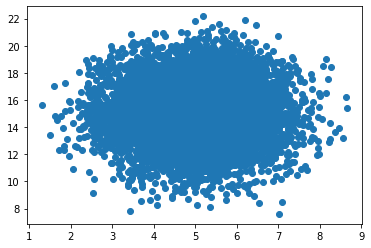

In [76]:
plt.scatter(x_values, y_values)

In [77]:
# As X and Y are not correlated, X has no value in predicting Y; therefore the regression parameter of x should go towards 0.

model_without_colliderbias = pm.Model()

with model_without_colliderbias:
    
    # Priors for unknown
    intercept = pm.Normal("intercept", mu=0, sigma=10)
    x_infl = pm.Normal("x_infl", mu=0, sigma=10)
    sigma = pm.HalfNormal("sigma", sigma=1)
    
    # Expected value of outcome
    mu = intercept + x_infl * x_values
    
    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal("Y_obs", mu=mu, sigma=sigma, observed=y_values)

In [78]:
map_estimate = pm.find_MAP(model=model_without_colliderbias)
map_estimate

{'intercept': array(14.99690099),
 'x_infl': array(0.01142307),
 'sigma_log__': array(0.69756764),
 'sigma': array(2.0088605)}

In [79]:
# When conditioned on Z, collider bias will be introduced. In this model X and Y should appear to be correlated. 

model_with_colliderbias = pm.Model()

with model_with_colliderbias:
    
    # Priors for unknown
    intercept = pm.Normal("intercept", mu=0, sigma=10)
    x_infl = pm.Normal("x_infl", mu=0, sigma=10)
    z_infl = pm.Normal("z_infl", mu=0, sigma=10)
    sigma = pm.HalfNormal("sigma", sigma=1)
    
    # Expected value of outcome
    mu = intercept + x_infl * x_values + z_infl * z_values
    
    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal("Y_obs", mu=mu, sigma=sigma, observed=y_values)

In [80]:
map_estimate = pm.find_MAP(model=model_with_colliderbias)
map_estimate

{'intercept': array(-0.06182428),
 'x_infl': array(-2.85656043),
 'z_infl': array(0.14279773),
 'sigma_log__': array(-3.19170313),
 'sigma': array(0.04110181)}